In [1]:
# Run in a Jupyter cell
%pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install scipy==1.11.4


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [4]:
# %% [markdown]
# ## Cell 2: MediaPipe Landmark Extraction and Augmentation
# %%
mp_pose = mp.solutions.pose

def extract_landmarks(image):
    with mp_pose.Pose(static_image_mode=True) as pose:
        results = pose.process(image)
        if not results.pose_landmarks:
            return None
        landmarks = []
        for lm in results.pose_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.visibility])
        return np.array(landmarks)

def augment_landmarks(landmarks, noise_std=0.01):
    # Add small Gaussian noise to each coordinate
    noise = np.random.normal(0, noise_std, landmarks.shape)
    return landmarks + noise

def process_image(img_path, augment=False):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    landmarks = extract_landmarks(image)
    if landmarks is not None and augment:
        landmarks = augment_landmarks(landmarks)
    return landmarks


In [5]:
# %% [markdown]
# ## Cell 3: Load and Prepare Dataset with Augmentation
# %%
DATASET_DIR = r"C:\Users\chara\OneDrive\Desktop\Yoga\Yoga Poses\TRAIN"  # Update as needed
CLASS_NAMES = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
print("Classes:", CLASS_NAMES)

X, y = [], []
for class_idx, class_name in enumerate(CLASS_NAMES):
    class_dir = os.path.join(DATASET_DIR, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        landmarks = process_image(img_path)
        if landmarks is not None:
            X.append(landmarks)
            y.append(class_idx)
            # Augment: Add 2x augmented samples per image
            for _ in range(2):
                aug_landmarks = process_image(img_path, augment=True)
                if aug_landmarks is not None:
                    X.append(aug_landmarks)
                    y.append(class_idx)

X = np.array(X)
y = np.array(y)
print(f"Total samples after augmentation: {len(X)}")


Classes: ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
Total samples after augmentation: 3123


In [6]:
# %% [markdown]
# ## Cell 4: Train-Test Split
# %%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


Train samples: 2654, Test samples: 469


In [7]:
# %% [markdown]
# ## Cell 5: Build Improved Neural Network
# %%
def build_pose_classifier(input_dim, num_classes):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    # Attention mechanism (squeeze-and-excitation)
    attn = layers.Dense(128, activation='sigmoid')(x)
    x = layers.Multiply()([x, attn])
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_pose_classifier(X.shape[1], len(CLASS_NAMES))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 99)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     25,600 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128)       │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 5)         │        325 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,125 (332.52 KB)

 Trainable params: 84,357 (329.52 KB)

 Non-trainable params: 768 (3.00 KB)

In [8]:
# %% [markdown]
# ## Cell 6: Train the Model with Callbacks
# %%
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1
)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_pose_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stop, lr_reduce, checkpoint],
    verbose=2
)


Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.20802, saving model to best_pose_model.h5


71/71 - 4s - 53ms/step - accuracy: 0.2244 - loss: 1.7666 - val_accuracy: 0.2080 - val_loss: 1.5710 - learning_rate: 1.0000e-04
Epoch 2/100

Epoch 2: val_accuracy improved from 0.20802 to 0.39850, saving model to best_pose_model.h5


71/71 - 0s - 6ms/step - accuracy: 0.3619 - loss: 1.4642 - val_accuracy: 0.3985 - val_loss: 1.4749 - learning_rate: 1.0000e-04
Epoch 3/100

Epoch 3: val_accuracy improved from 0.39850 to 0.49875, saving model to best_pose_model.h5


71/71 - 0s - 6ms/step - accuracy: 0.4780 - loss: 1.2587 - val_accuracy: 0.4987 - val_loss: 1.3492 - learning_rate: 1.0000e-04
Epoch 4/100

Epoch 4: val_accuracy improved from 0.49875 to 0.59900, saving model to best_pose_model.h5


71/71 - 1s - 9ms/step - accuracy: 0.5543 - loss: 1.1150 - val_accuracy: 0.5990 - val_loss: 1.1944 - learning_rate: 1.0000e-04
Epoch 5/100

Epoch 5: val_accuracy improved from 0.59900 to 0.62657, saving model to best_pose_model.h5


71/71 - 1s - 8ms/step - accuracy: 0.6053 - loss: 1.0111 - val_accuracy: 0.6266 - val_loss: 1.0284 - learning_rate: 1.0000e-04
Epoch 6/100

Epoch 6: val_accuracy improved from 0.62657 to 0.68922, saving model to best_pose_model.h5


71/71 - 0s - 6ms/step - accuracy: 0.6430 - loss: 0.9316 - val_accuracy: 0.6892 - val_loss: 0.8837 - learning_rate: 1.0000e-04
Epoch 7/100

Epoch 7: val_accuracy improved from 0.68922 to 0.74687, saving model to best_pose_model.h5


71/71 - 0s - 6ms/step - accuracy: 0.6661 - loss: 0.8838 - val_accuracy: 0.7469 - val_loss: 0.7684 - learning_rate: 1.0000e-04
Epoch 8/100

Epoch 8: val_accuracy improved from 0.74687 to 0.75940, saving model to best_pose_model.h5


71/71 - 0s - 6ms/step - accuracy: 0.6882 - loss: 0.8397 - val_accuracy: 0.7594 - val_loss: 0.6740 - learning_rate: 1.0000e-04
Epoch 9/100

Epoch 9: val_accuracy improved from 0.75940 to 0.77193, saving model to best_pose_model.h5


71/71 - 0s - 6ms/step - accuracy: 0.7171 - loss: 0.7902 - val_accuracy: 0.7719 - val_loss: 0.6166 - learning_rate: 1.0000e-04
Epoch 10/100

Epoch 10: val_accuracy improved from 0.77193 to 0.79699, saving model to best_pose_model.h5


71/71 - 1s - 9ms/step - accuracy: 0.7326 - loss: 0.7497 - val_accuracy: 0.7970 - val_loss: 0.5719 - learning_rate: 1.0000e-04
Epoch 11/100

Epoch 11: val_accuracy improved from 0.79699 to 0.81203, saving model to best_pose_model.h5


71/71 - 1s - 9ms/step - accuracy: 0.7415 - loss: 0.7258 - val_accuracy: 0.8120 - val_loss: 0.5417 - learning_rate: 1.0000e-04
Epoch 12/100

Epoch 12: val_accuracy did not improve from 0.81203
71/71 - 1s - 9ms/step - accuracy: 0.7472 - loss: 0.6729 - val_accuracy: 0.8120 - val_loss: 0.5236 - learning_rate: 1.0000e-04
Epoch 13/100

Epoch 13: val_accuracy improved from 0.81203 to 0.82456, saving model to best_pose_model.h5


71/71 - 1s - 8ms/step - accuracy: 0.7659 - loss: 0.6688 - val_accuracy: 0.8246 - val_loss: 0.5042 - learning_rate: 1.0000e-04
Epoch 14/100

Epoch 14: val_accuracy improved from 0.82456 to 0.84461, saving model to best_pose_model.h5


71/71 - 0s - 6ms/step - accuracy: 0.7765 - loss: 0.6452 - val_accuracy: 0.8446 - val_loss: 0.4707 - learning_rate: 1.0000e-04
Epoch 15/100

Epoch 15: val_accuracy improved from 0.84461 to 0.85464, saving model to best_pose_model.h5


71/71 - 1s - 9ms/step - accuracy: 0.7792 - loss: 0.6271 - val_accuracy: 0.8546 - val_loss: 0.4576 - learning_rate: 1.0000e-04
Epoch 16/100

Epoch 16: val_accuracy did not improve from 0.85464
71/71 - 0s - 4ms/step - accuracy: 0.7987 - loss: 0.5798 - val_accuracy: 0.8521 - val_loss: 0.4412 - learning_rate: 1.0000e-04
Epoch 17/100

Epoch 17: val_accuracy improved from 0.85464 to 0.86216, saving model to best_pose_model.h5


71/71 - 0s - 5ms/step - accuracy: 0.7920 - loss: 0.5919 - val_accuracy: 0.8622 - val_loss: 0.4284 - learning_rate: 1.0000e-04
Epoch 18/100

Epoch 18: val_accuracy improved from 0.86216 to 0.86967, saving model to best_pose_model.h5


71/71 - 0s - 7ms/step - accuracy: 0.7938 - loss: 0.5866 - val_accuracy: 0.8697 - val_loss: 0.4127 - learning_rate: 1.0000e-04
Epoch 19/100

Epoch 19: val_accuracy improved from 0.86967 to 0.87218, saving model to best_pose_model.h5


71/71 - 1s - 10ms/step - accuracy: 0.8142 - loss: 0.5433 - val_accuracy: 0.8722 - val_loss: 0.4063 - learning_rate: 1.0000e-04
Epoch 20/100

Epoch 20: val_accuracy improved from 0.87218 to 0.87719, saving model to best_pose_model.h5


71/71 - 1s - 9ms/step - accuracy: 0.8284 - loss: 0.5319 - val_accuracy: 0.8772 - val_loss: 0.4089 - learning_rate: 1.0000e-04
Epoch 21/100

Epoch 21: val_accuracy improved from 0.87719 to 0.88471, saving model to best_pose_model.h5


71/71 - 1s - 10ms/step - accuracy: 0.8239 - loss: 0.5141 - val_accuracy: 0.8847 - val_loss: 0.3856 - learning_rate: 1.0000e-04
Epoch 22/100

Epoch 22: val_accuracy improved from 0.88471 to 0.88722, saving model to best_pose_model.h5


71/71 - 1s - 9ms/step - accuracy: 0.8271 - loss: 0.5026 - val_accuracy: 0.8872 - val_loss: 0.3706 - learning_rate: 1.0000e-04
Epoch 23/100

Epoch 23: val_accuracy did not improve from 0.88722
71/71 - 0s - 7ms/step - accuracy: 0.8231 - loss: 0.5146 - val_accuracy: 0.8872 - val_loss: 0.3799 - learning_rate: 1.0000e-04
Epoch 24/100

Epoch 24: val_accuracy did not improve from 0.88722
71/71 - 0s - 6ms/step - accuracy: 0.8381 - loss: 0.4823 - val_accuracy: 0.8797 - val_loss: 0.3687 - learning_rate: 1.0000e-04
Epoch 25/100

Epoch 25: val_accuracy improved from 0.88722 to 0.89223, saving model to best_pose_model.h5


71/71 - 0s - 6ms/step - accuracy: 0.8271 - loss: 0.4956 - val_accuracy: 0.8922 - val_loss: 0.3462 - learning_rate: 1.0000e-04
Epoch 26/100

Epoch 26: val_accuracy improved from 0.89223 to 0.89474, saving model to best_pose_model.h5


71/71 - 0s - 6ms/step - accuracy: 0.8417 - loss: 0.4535 - val_accuracy: 0.8947 - val_loss: 0.3386 - learning_rate: 1.0000e-04
Epoch 27/100

Epoch 27: val_accuracy did not improve from 0.89474
71/71 - 0s - 5ms/step - accuracy: 0.8395 - loss: 0.4734 - val_accuracy: 0.8897 - val_loss: 0.3389 - learning_rate: 1.0000e-04
Epoch 28/100

Epoch 28: val_accuracy improved from 0.89474 to 0.90476, saving model to best_pose_model.h5


71/71 - 0s - 5ms/step - accuracy: 0.8528 - loss: 0.4445 - val_accuracy: 0.9048 - val_loss: 0.3309 - learning_rate: 1.0000e-04
Epoch 29/100

Epoch 29: val_accuracy did not improve from 0.90476
71/71 - 0s - 4ms/step - accuracy: 0.8568 - loss: 0.4384 - val_accuracy: 0.9048 - val_loss: 0.3262 - learning_rate: 1.0000e-04
Epoch 30/100

Epoch 30: val_accuracy did not improve from 0.90476
71/71 - 0s - 4ms/step - accuracy: 0.8639 - loss: 0.4224 - val_accuracy: 0.9023 - val_loss: 0.3185 - learning_rate: 1.0000e-04
Epoch 31/100

Epoch 31: val_accuracy improved from 0.90476 to 0.91479, saving model to best_pose_model.h5


71/71 - 0s - 6ms/step - accuracy: 0.8466 - loss: 0.4450 - val_accuracy: 0.9148 - val_loss: 0.3221 - learning_rate: 1.0000e-04
Epoch 32/100

Epoch 32: val_accuracy did not improve from 0.91479
71/71 - 0s - 5ms/step - accuracy: 0.8568 - loss: 0.4270 - val_accuracy: 0.8947 - val_loss: 0.3171 - learning_rate: 1.0000e-04
Epoch 33/100

Epoch 33: val_accuracy did not improve from 0.91479
71/71 - 1s - 7ms/step - accuracy: 0.8568 - loss: 0.4014 - val_accuracy: 0.9023 - val_loss: 0.3143 - learning_rate: 1.0000e-04
Epoch 34/100

Epoch 34: val_accuracy did not improve from 0.91479
71/71 - 1s - 7ms/step - accuracy: 0.8599 - loss: 0.4163 - val_accuracy: 0.8997 - val_loss: 0.3030 - learning_rate: 1.0000e-04
Epoch 35/100

Epoch 35: val_accuracy did not improve from 0.91479
71/71 - 1s - 8ms/step - accuracy: 0.8545 - loss: 0.4218 - val_accuracy: 0.9048 - val_loss: 0.3040 - learning_rate: 1.0000e-04
Epoch 36/100

Epoch 36: val_accuracy did not improve from 0.91479
71/71 - 0s - 4ms/step - accuracy: 0.8710

71/71 - 0s - 5ms/step - accuracy: 0.8776 - loss: 0.3831 - val_accuracy: 0.9173 - val_loss: 0.2912 - learning_rate: 1.0000e-04
Epoch 38/100

Epoch 38: val_accuracy did not improve from 0.91729
71/71 - 0s - 4ms/step - accuracy: 0.8741 - loss: 0.3888 - val_accuracy: 0.9148 - val_loss: 0.2856 - learning_rate: 1.0000e-04
Epoch 39/100

Epoch 39: val_accuracy did not improve from 0.91729
71/71 - 1s - 9ms/step - accuracy: 0.8807 - loss: 0.3820 - val_accuracy: 0.9148 - val_loss: 0.2796 - learning_rate: 1.0000e-04
Epoch 40/100

Epoch 40: val_accuracy improved from 0.91729 to 0.92231, saving model to best_pose_model.h5


71/71 - 1s - 10ms/step - accuracy: 0.8860 - loss: 0.3459 - val_accuracy: 0.9223 - val_loss: 0.2772 - learning_rate: 1.0000e-04
Epoch 41/100

Epoch 41: val_accuracy did not improve from 0.92231
71/71 - 1s - 10ms/step - accuracy: 0.8665 - loss: 0.3811 - val_accuracy: 0.9198 - val_loss: 0.2760 - learning_rate: 1.0000e-04
Epoch 42/100

Epoch 42: val_accuracy did not improve from 0.92231
71/71 - 1s - 14ms/step - accuracy: 0.8812 - loss: 0.3710 - val_accuracy: 0.9198 - val_loss: 0.2748 - learning_rate: 1.0000e-04
Epoch 43/100

Epoch 43: val_accuracy did not improve from 0.92231
71/71 - 0s - 4ms/step - accuracy: 0.8745 - loss: 0.3740 - val_accuracy: 0.9148 - val_loss: 0.2808 - learning_rate: 1.0000e-04
Epoch 44/100

Epoch 44: val_accuracy did not improve from 0.92231
71/71 - 0s - 5ms/step - accuracy: 0.8838 - loss: 0.3545 - val_accuracy: 0.9198 - val_loss: 0.2770 - learning_rate: 1.0000e-04
Epoch 45/100

Epoch 45: val_accuracy did not improve from 0.92231
71/71 - 0s - 5ms/step - accuracy: 0.8

71/71 - 1s - 8ms/step - accuracy: 0.8887 - loss: 0.3368 - val_accuracy: 0.9248 - val_loss: 0.2682 - learning_rate: 1.0000e-04
Epoch 49/100

Epoch 49: val_accuracy did not improve from 0.92481
71/71 - 0s - 5ms/step - accuracy: 0.8860 - loss: 0.3362 - val_accuracy: 0.9223 - val_loss: 0.2589 - learning_rate: 1.0000e-04
Epoch 50/100

Epoch 50: val_accuracy improved from 0.92481 to 0.92982, saving model to best_pose_model.h5


71/71 - 0s - 6ms/step - accuracy: 0.8874 - loss: 0.3449 - val_accuracy: 0.9298 - val_loss: 0.2590 - learning_rate: 1.0000e-04
Epoch 51/100

Epoch 51: val_accuracy did not improve from 0.92982
71/71 - 0s - 7ms/step - accuracy: 0.8882 - loss: 0.3271 - val_accuracy: 0.9298 - val_loss: 0.2486 - learning_rate: 1.0000e-04
Epoch 52/100

Epoch 52: val_accuracy did not improve from 0.92982
71/71 - 1s - 7ms/step - accuracy: 0.8984 - loss: 0.3133 - val_accuracy: 0.9198 - val_loss: 0.2650 - learning_rate: 1.0000e-04
Epoch 53/100

Epoch 53: val_accuracy did not improve from 0.92982
71/71 - 1s - 12ms/step - accuracy: 0.9002 - loss: 0.3101 - val_accuracy: 0.9248 - val_loss: 0.2643 - learning_rate: 1.0000e-04
Epoch 54/100

Epoch 54: val_accuracy did not improve from 0.92982
71/71 - 1s - 13ms/step - accuracy: 0.8851 - loss: 0.3307 - val_accuracy: 0.9273 - val_loss: 0.2467 - learning_rate: 1.0000e-04
Epoch 55/100

Epoch 55: val_accuracy did not improve from 0.92982
71/71 - 1s - 12ms/step - accuracy: 0.9

71/71 - 1s - 14ms/step - accuracy: 0.9033 - loss: 0.3097 - val_accuracy: 0.9323 - val_loss: 0.2404 - learning_rate: 1.0000e-04
Epoch 58/100

Epoch 58: val_accuracy did not improve from 0.93233
71/71 - 1s - 13ms/step - accuracy: 0.8993 - loss: 0.3104 - val_accuracy: 0.9323 - val_loss: 0.2403 - learning_rate: 1.0000e-04
Epoch 59/100

Epoch 59: val_accuracy improved from 0.93233 to 0.93484, saving model to best_pose_model.h5


71/71 - 1s - 19ms/step - accuracy: 0.8962 - loss: 0.3092 - val_accuracy: 0.9348 - val_loss: 0.2484 - learning_rate: 1.0000e-04
Epoch 60/100

Epoch 60: val_accuracy did not improve from 0.93484
71/71 - 1s - 15ms/step - accuracy: 0.9024 - loss: 0.2968 - val_accuracy: 0.9323 - val_loss: 0.2344 - learning_rate: 1.0000e-04
Epoch 61/100

Epoch 61: val_accuracy did not improve from 0.93484
71/71 - 1s - 15ms/step - accuracy: 0.8962 - loss: 0.3116 - val_accuracy: 0.9298 - val_loss: 0.2397 - learning_rate: 1.0000e-04
Epoch 62/100

Epoch 62: val_accuracy did not improve from 0.93484
71/71 - 1s - 14ms/step - accuracy: 0.9020 - loss: 0.3010 - val_accuracy: 0.9298 - val_loss: 0.2412 - learning_rate: 1.0000e-04
Epoch 63/100

Epoch 63: val_accuracy did not improve from 0.93484
71/71 - 1s - 13ms/step - accuracy: 0.9038 - loss: 0.3126 - val_accuracy: 0.9348 - val_loss: 0.2370 - learning_rate: 1.0000e-04
Epoch 64/100

Epoch 64: val_accuracy did not improve from 0.93484
71/71 - 1s - 16ms/step - accuracy: 

71/71 - 2s - 23ms/step - accuracy: 0.9051 - loss: 0.2827 - val_accuracy: 0.9398 - val_loss: 0.2253 - learning_rate: 5.0000e-05
Epoch 74/100

Epoch 74: val_accuracy did not improve from 0.93985
71/71 - 1s - 8ms/step - accuracy: 0.9055 - loss: 0.2773 - val_accuracy: 0.9348 - val_loss: 0.2307 - learning_rate: 5.0000e-05
Epoch 75/100

Epoch 75: val_accuracy did not improve from 0.93985
71/71 - 0s - 7ms/step - accuracy: 0.9144 - loss: 0.2625 - val_accuracy: 0.9373 - val_loss: 0.2223 - learning_rate: 5.0000e-05
Epoch 76/100

Epoch 76: val_accuracy did not improve from 0.93985
71/71 - 1s - 7ms/step - accuracy: 0.9051 - loss: 0.2863 - val_accuracy: 0.9373 - val_loss: 0.2220 - learning_rate: 5.0000e-05
Epoch 77/100

Epoch 77: val_accuracy did not improve from 0.93985
71/71 - 1s - 8ms/step - accuracy: 0.9113 - loss: 0.2826 - val_accuracy: 0.9348 - val_loss: 0.2246 - learning_rate: 5.0000e-05
Epoch 78/100

Epoch 78: val_accuracy did not improve from 0.93985
71/71 - 1s - 8ms/step - accuracy: 0.915

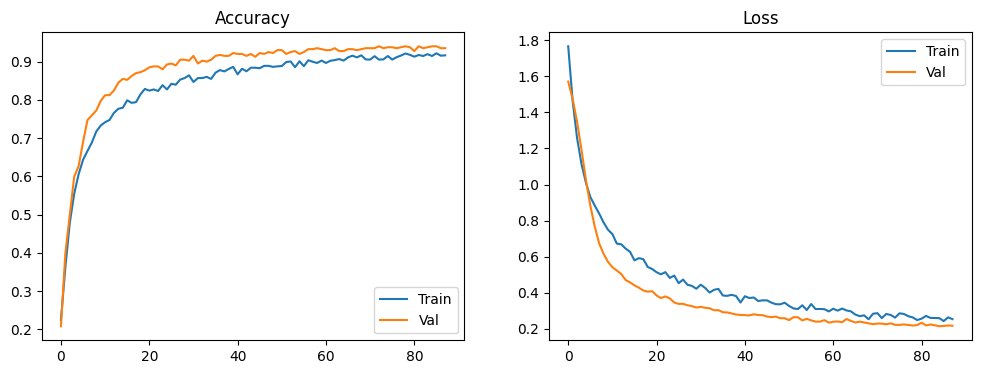

Test Accuracy: 0.9595
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

     downdog       0.98      0.97      0.97        90
     goddess       0.95      0.90      0.92        77
       plank       0.95      0.99      0.97       118
        tree       0.96      0.96      0.96        72
    warrior2       0.96      0.96      0.96       112

    accuracy                           0.96       469
   macro avg       0.96      0.96      0.96       469
weighted avg       0.96      0.96      0.96       469



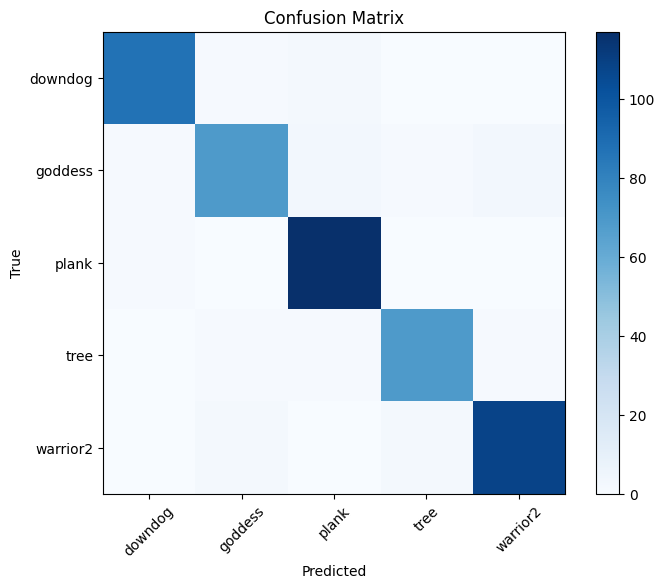

In [9]:
# %% [markdown]
# ## Cell 7: Evaluate Model Performance
# %%
# Accuracy and loss curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

# Test set performance
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Detailed report
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.title("Confusion Matrix")
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES, rotation=45)
plt.yticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES)
plt.show()


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import mediapipe as mp

# Load the trained model
model = load_model('best_yoga_model.h5')

# Replace with your yoga pose class names in the correct order
CLASS_NAMES = ['warrior1', 'warrior2', 'triangle', 'tree', 'downward_dog']

mp_pose = mp.solutions.pose

def calculate_angle(a, b, c):
    a = np.array(a[:2])
    b = np.array(b[:2])
    c = np.array(c[:2])
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    if angle > 180.0:
        angle = 360-angle
    return angle

def get_live_landmarks(frame):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    with mp_pose.Pose(static_image_mode=False) as pose:
        results = pose.process(image)
        if not results.pose_landmarks:
            return None, None
        landmarks = []
        for lm in results.pose_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.visibility])
        return landmarks, results.pose_landmarks

def live_yoga_coach():
    cap = cv2.VideoCapture(0)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            continue
        landmarks, pose_landmarks = get_live_landmarks(frame)
        if landmarks is not None:
            # <<<< CORRECTED SHAPE HERE <<<<
            landmarks_np = np.array(landmarks).reshape(33, 3)  # 33 keypoints, 3 values each
            pred = model.predict(np.expand_dims(landmarks_np, axis=0), verbose=0)
            pose_class = CLASS_NAMES[np.argmax(pred)]
            confidence = np.max(pred)
            lm = landmarks_np
            left_shoulder = lm[11]
            left_elbow = lm[13]
            left_wrist = lm[15]
            angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
            feedback = []
            if pose_class == "warrior2" and angle < 160:
                feedback.append("Straighten your left arm")
            cv2.putText(frame, f"{pose_class} ({confidence:.2f})", (10,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            for i, text in enumerate(feedback):
                cv2.putText(frame, text, (10,70+i*30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.imshow('Yoga Pose Coach', frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Run the live yoga coach
live_yoga_coach()


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(1, 33, 3), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (1, 33, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 33, 3), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

: 